## Building an optimized CNN Model for Morgan fingerprints

This Notebook will uses Keras Tuner to find the best hyperparameters for a CNN model which will label molecules according to their Morgan fingerprints

#### In case the requirements.txt file won't work

In [1]:
#pip install keras_tuner

### Imports

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy import unique
from numpy import argmax
from keras_tuner import RandomSearch
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

### Loading data

In [15]:
all_drugs = pd.read_pickle('morgan_and_mac.pkl')

In [16]:
drugs = all_drugs
drugs.head()

,CID,Molecule,drug_class,drug_class_code,FeatInvariants,ConnInvariants,Morgan2FP,MACCSKeys,AtomPairFP,TopTorFP,AvalonFP,PubchemFP,CactvsFP
0,24769,<rdkit.Chem.rdchem.Mol object at 0x000002CDADD...,hematologic,7,"[0, 18, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 8...","[2968968094, 2976033787, 2968968094, 297603378...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
1,134694070,<rdkit.Chem.rdchem.Mol object at 0x000002CDADD...,cardio,3,"[0, 0, 2, 0, 17, 17, 4, 4, 4, 6, 4, 4, 6, 4, 4...","[2968968094, 2976033787, 2968968094, 297603378...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
2,5121,<rdkit.Chem.rdchem.Mol object at 0x000002CDADD...,antiinfective,0,"[0, 0, 2, 0, 2, 0, 0, 16, 4, 4, 4, 4, 4, 4, 8]","[2968968094, 2976033787, 2968968094, 297603378...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
3,4660557,<rdkit.Chem.rdchem.Mol object at 0x000002CDADD...,cns,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 4, 4, 4, 4,...","[2968968094, 2976033787, 2968968094, 297603378...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
4,122175,<rdkit.Chem.rdchem.Mol object at 0x000002CDADD...,antineoplastic,2,"[0, 0, 0, 0, 0, 0, 0, 19, 19]","[2968968094, 2976033787, 2968968094, 297603378...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."


### Prepare the data

In [17]:
drugs.columns

Index(['CID', 'Molecule', 'drug_class', 'drug_class_code', 'FeatInvariants',
       'ConnInvariants', 'Morgan2FP', 'MACCSKeys', 'AtomPairFP', 'TopTorFP',
       'AvalonFP', 'PubchemFP', 'CactvsFP'],
      dtype='object')

We have found that Morgan fingerprints are the ones returning the best accuracy in a CNN model (look select_fingerprints.ipynb)

In [18]:
#Choose fingerprints to train with
X = drugs['Morgan2FP']
y = drugs['drug_class_code']

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Reshaping the arrays to fit in the model
x_train = np.array(list(X_train))
x_test = np.array(list(X_test))
print('Shape x_train: ', x_train.shape)
n_classes = len(unique(y_train))
print('Number of classes: ', n_classes)
x_train= x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test= x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print('Reshapep x_train: ', x_train.shape)
in_shape = x_train.shape[1:]
print('In_shape: ', in_shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Shape x_train:  (4854, 2048)
Number of classes:  12
Reshapep x_train:  (4854, 2048, 1)
In_shape:  (2048, 1)
(4854, 2048, 1) (4854,)
(2081, 2048, 1) (2081,)


### Tuning the model

Building the model

In [21]:
# These piece of code is heavily inspired by this blog "https://www.analyticsvidhya.com/blog/2021/06/create-convolutional-neural-network-model-and-optimize-using-keras-tuner-deep-learning/"

def build_model(hp):
    """
    Function that chooses the best hyperparameters for a CNN model and then compiles it.
    Input: a set of hyperparamneters
    Output: a cnn model
    """
    # Create model object
    model = keras.Sequential([
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(2048, 1)),
    keras.layers.MaxPool1D(hp.Int('pool_size', min_value=2, max_value=6)),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu', kernel_initializer = 'he_uniform'
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(12, activation='softmax')
    ])
    # Compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],)
    return model

Tuning the model

In [23]:
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5,
                    directory = os.path.join('temp','tuner', 'RS_tuned_model'))
tuner.search(x_train,y_train,epochs=3,validation_data=(x_train,y_train))

Trial 5 Complete [00h 02m 11s]
val_accuracy: 0.9184178113937378

Best val_accuracy So Far: 0.9184178113937378
Total elapsed time: 00h 08m 35s
INFO:tensorflow:Oracle triggered exit


Obtain and save the model

In [25]:
tuned_model = tuner.get_best_models(num_models=1)[0]
tuned_model.summary()
tuned_model.save(os.path.join('compiled_models','tuned', 'opt_morgan_model'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2044, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1022, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65408)             0         
                                                                 
 dense (Dense)               (None, 96)                6279264   
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                1164      
                                                        

INFO:tensorflow:Assets written to: compiled_models\tuned\opt_morgan_model\assets


INFO:tensorflow:Assets written to: compiled_models\tuned\opt_morgan_model\assets


### Fit model and choose number of epochs

Set EarlyStopping and ModelCheckpoint to select a model with the optimal number of epochs

In [28]:
# Configure early stopping
es = EarlyStopping(monitor='accuracy', patience=10)
mc = ModelCheckpoint(filepath = os.path.join('compiled_models','checkpoints', '{epoch:02d}-{val_accuracy:.3f}.hdf5'), monitor = 'val_loss', save_best_only = True)

# Fit the model
history = tuned_model.fit(x_test[:1000], y_test[:1000], epochs=200, batch_size=128, verbose=1, validation_split = 0.2, initial_epoch=3, callbacks = [es,mc])

# Evaluate the model
loss, acc = tuned_model.evaluate(x_test[:1000], y_test[:1000], verbose=1)

Epoch 4/200
7/7 [==============================] - 3s 449ms/step - loss: 0.1612 - accuracy: 0.3575 - val_loss: 0.8818 - val_accuracy: 0.3000
Epoch 5/200
7/7 [==============================] - 3s 435ms/step - loss: 0.1681 - accuracy: 0.3462 - val_loss: 0.8981 - val_accuracy: 0.3050
Epoch 6/200
7/7 [==============================] - 3s 441ms/step - loss: 0.1550 - accuracy: 0.3487 - val_loss: 0.9155 - val_accuracy: 0.3100
Epoch 7/200
7/7 [==============================] - 3s 464ms/step - loss: 0.1434 - accuracy: 0.3575 - val_loss: 0.9273 - val_accuracy: 0.3100
Epoch 8/200
7/7 [==============================] - 3s 465ms/step - loss: 0.1431 - accuracy: 0.3562 - val_loss: 0.9272 - val_accuracy: 0.2900
Epoch 9/200
7/7 [==============================] - 3s 446ms/step - loss: 0.1291 - accuracy: 0.3550 - val_loss: 0.9401 - val_accuracy: 0.2900
Epoch 10/200
7/7 [==============================] - 3s 469ms/step - loss: 0.1104 - accuracy: 0.3525 - val_loss: 0.9693 - val_accuracy: 0.3000
Epoch 11/200

In [33]:
# Getting test predictions
y_pred = tuned_model.predict(x_test[1000:])
y_pred_list = [argmax(x) for x in y_pred]

34/34 [==============================] - 1s 31ms/step


In [34]:
# Save predictions
y_pred_ser = pd.Series(y_pred_list)
y_pred_ser.to_pickle(path= os.path.join('predictions', 'y_preds.pkl'))

#### Visualization of models accuracy

In [35]:
# Precission and recall for every variable
print(metrics.classification_report(y_test[1000:],y_pred_list))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       382
           1       0.83      0.74      0.78        46
           2       0.64      0.85      0.73       179
           3       0.75      0.60      0.67       126
           4       0.67      0.69      0.68       168
           5       1.00      0.24      0.38        17
           6       0.97      0.69      0.81        42
           7       0.83      0.39      0.53        49
           8       0.92      0.71      0.80        31
           9       0.95      0.90      0.93        21
          10       0.80      0.44      0.57        18
          11       0.00      0.00      0.00         2

    accuracy                           0.76      1081
   macro avg       0.76      0.60      0.64      1081
weighted avg       0.77      0.76      0.75      1081



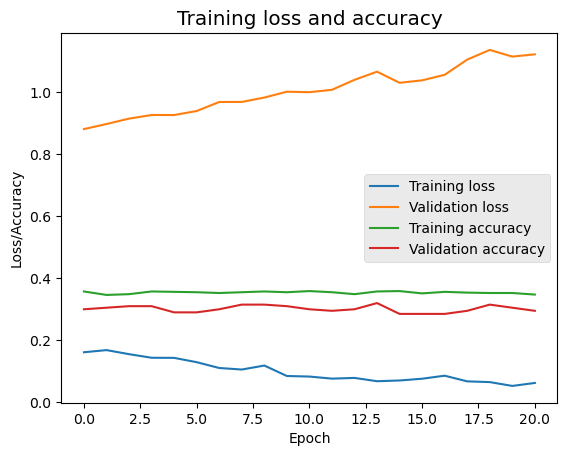

In [36]:
#Learning curve visualization

fig,ax = plt.subplots()
plt.style.use('ggplot')

epochs = len(history.history['loss'])
epoch_values = list(range(epochs))

ax.plot(epoch_values, history.history['loss'], label='Training loss')
ax.plot(epoch_values, history.history['val_loss'], label='Validation loss')
ax.plot(epoch_values, history.history['accuracy'], label='Training accuracy')
ax.plot(epoch_values, history.history['val_accuracy'], label='Validation accuracy')

ax.set_title('Training loss and accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.legend()
plt.show()